In [1]:
import argparse
import torch
import pickle 
import numpy as np 
import os 
import math 
import random 
import sys
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.io

import data 

from sklearn.decomposition import PCA
from torch import nn, optim
from torch.nn import functional as F

from detm import DETM
from utils import nearest_neighbors, get_topic_coherence

import pandas as pd

device: cuda:3
device: cuda:3


In [3]:
from sklearn import cluster
from sklearn import metrics

In [4]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [5]:
root_dir = '/home/yiyi/nlp_tm/'

In [6]:
num_topics = 75
filepath = os.path.join(root_dir, f'datasets/df_detm_topics_k{num_topics}_confidence.csv')

In [8]:
df = pd.read_csv(filepath, index_col=0)

In [9]:
df.head()

,text_id,year_id,country_code,id.1,text,created_at,geo,author_id,entities,year,month,day,preprocessed_text,topic,cossim
id,,,,,,,,,,,,,,,
285908615561363456,"[13807, 12242, 16517, 4854, 16885, 13840, 7284...",0,GB,285908615561363456,"Completely missed the New Year beginning, too ...",2013-01-01T00:41:40.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",174028844,"{'hashtags': [{'start': 59, 'end': 80, 'tag': ...",2013,1,1,completely miss new year beginning engross car...,17,0.056427
285909630868152320,"[11403, 16517, 13618, 1431, 1404, 1881]",0,DE,285909630868152320,happy new year all of you who lives in #europe...,2013-01-01T00:45:42.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",615040794,"{'hashtags': [{'start': 39, 'end': 46, 'tag': ...",2013,1,1,happy new year live europe party start right,17,0.046433
285915248383361026,"[638, 2601, 20286]",0,GB,285915248383361026,Damien Sandow is awesome #YoureWelcome,2013-01-01T01:08:01.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",73127632,"{'annotations': [{'start': 0, 'end': 12, 'prob...",2013,1,1,damien sandow awesome yourewelcome,17,0.048438
285921849446117376,"[17018, 9987]",0,GB,285921849446117376,Ryan was looking at me like I needed to be in ...,2013-01-01T01:34:15.000Z,"{'place_id': 'a3f4491c1a3bfe66', 'coordinates'...",398595226,"{'annotations': [{'start': 0, 'end': 3, 'proba...",2013,1,1,ryan look like need asylum troublemaker come,17,0.043933
285922536942866432,"[2721, 16517, 12121]",0,GB,285922536942866432,#welcome #to #2013 #i #hope #this #year #is #b...,2013-01-01T01:36:59.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",191530036,"{'hashtags': [{'start': 0, 'end': 8, 'tag': 'w...",2013,1,1,welcome hope year well litte world know,17,0.052431


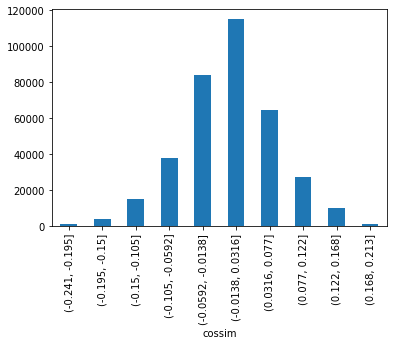

In [12]:
df['text'].groupby(pd.cut(df['cossim'], 10)).count().plot(kind='bar')